In [2]:
import yaml
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as TVDatasets

import torch_geometric
from torch_geometric.data import Data as GraphData 

from torch_geometric.nn import GCNConv, GATConv, APPNP, SAGEConv
from torch_geometric.nn.models.label_prop import LabelPropagation
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

from sklearn.metrics import classification_report
# from sklearn.calibration import CalibrationDisplay

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Torch is running on {device}")


import sys
from gnn_cp.data.data_manager import GraphDataManager
from gnn_cp.models.graph_models import GCN, GAT, APPNPNet, SAGE
from gnn_cp.models.model_manager import GraphModelManager
from gnn_cp.data.utils import make_dataset_instances
import gnn_cp.cp.transformations as cp_t
import gnn_cp.cp.graph_transformations as cp_gt
from gnn_cp.cp.graph_cp import GraphCP

Torch is running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda


In [3]:
config_file_dir = "../baselines/config.yaml"
results_dir = "../baselines/results"
figures_dir = "./result-storage"

In [12]:
# loading the baseline settings
with open(config_file_dir, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
general_dataset_config = config.get("baseline", {}).get("general_dataset_config", {})


assert os.path.isdir(results_dir), "The results path does not exist!"

models_cache_dir = os.path.join(results_dir, "models")
assert os.path.isdir(models_cache_dir), "Directory to trained models is not found! Maybe first tun the make_baselines.py file"
data_dir = os.path.join(results_dir, "datasets")
assert os.path.isdir(data_dir), "Directory to Data Files is not found!"
splits_dir = os.path.join(results_dir, "splits")
assert os.path.isdir(splits_dir), "Directory to Data Splits is not found!"

dataset_names = list(config.get("baseline", {}).get("datasets", {}).keys())
models_config = config.get("baseline", {}).get("models", {})
model_classes = list(models_config.keys())

# Making a directory to store results for CPs
cp_results_dir = os.path.join(results_dir, "cp_results")
if not os.path.isdir(cp_results_dir):
    os.mkdir(cp_results_dir)


# region
# Making dataset-split and model instances
dataset_str_list = '\n'.join([f'{i}: {dataset_name}' for i, dataset_name in enumerate(dataset_names)])
dataset_name_idx = int(input(f"specify the dataset index:\n{dataset_str_list}\n"))
dataset_key = dataset_names[int(dataset_name_idx)]

model_str_list = '\n'.join([f'{i}: {model_name}' for i, model_name in enumerate(model_classes)])
model_class_idx = int(input(f"specify the model index:\n{model_str_list}\n"))
model_class_name = model_classes[model_class_idx]

dataset_manager = GraphDataManager(data_dir, splits_dir)
dataset = dataset_manager.get_dataset_from_key(dataset_key).data

print(f"dataset = {dataset_key}")
instances = make_dataset_instances(data_dir, splits_dir, models_cache_dir, dataset_key, model_class_name, models_config)

instances_accuracy = [instance["accuracy"] for instance in instances]
print(f"acc={np.mean(instances_accuracy)} +- {np.std(instances_accuracy)}")
best_model_accuracy = np.max(instances_accuracy)

instances_logits = [
    instance["model"].predict(dataset) for instance in instances
]

specify the dataset index:
0: cora_ml
1: pubmed
2: citeseer
3: coauthor_cs
4: coauthor_physics
5: amazon_computers
6: amazon_photo
 3
specify the model index:
0: GCN
1: GAT
2: SAGE
3: MLP
4: APPNPNet
 0


dataset = coauthor_cs
Dataset Loaded Successfully!
Following labeled splits:
class 0: train=20, val=20
class 1: train=20, val=20
class 2: train=20, val=20
class 3: train=20, val=20
class 4: train=20, val=20
class 5: train=20, val=20
class 6: train=20, val=20
class 7: train=20, val=20
class 8: train=20, val=20
class 9: train=20, val=20
class 10: train=20, val=20
class 11: train=20, val=20
class 12: train=20, val=20
class 13: train=20, val=20
class 14: train=20, val=20
Loading Models
Loading Models GCN
Accuracy: 0.909203180510912 +- 0.007846580681401144
acc=0.909203180510912 +- 0.007846580681401144


In [13]:
tuning_fraction = np.round(instances[0]["train_idx"].shape[0] / instances[0]["test_idx"].shape[0], 3)

lambda_vals = np.arange(0, 1.01, 0.01).round(3)
accuracy = np.max(instances_accuracy)
coverage_values = np.arange(start=accuracy.round(2), stop=0.99, step=0.005).round(3)
fixed_neigh_coef = 0.6
selected_coverage = coverage_values[len(coverage_values)//2]


def singleton_hit(pred_set, true_mask):
    one_sized_pred = (pred_set.sum(axis=1) == 1)
    result = pred_set[true_mask][one_sized_pred].sum().item() / pred_set.shape[0]
    return result

singleton_hit_metric = lambda pred_set, true_mask: singleton_hit(pred_set, true_mask)
set_size_metric = lambda pred_set, true_mask: GraphCP.average_set_size(pred_set)
coverage_metric = lambda pred_set, true_mask: GraphCP.coverage(pred_set, true_mask)
argmax_accuracy = lambda pred_set, true_mask: GraphCP.argmax_accuracy(pred_set, true_mask)

metrics_dict = {
    "empi_coverage": coverage_metric,
    "average_set_size": set_size_metric,
    "singleton_hit": singleton_hit_metric
}

k_reg_range = np.arange(0, dataset.y.max().cpu().numpy(), 1).astype(int)
penalty_range = np.arange(0, 5.01, 0.01).round(3)

pivot_coverages = np.array([(1 + best_model_accuracy * 2) / 3, (1 + best_model_accuracy) / 2, (2 + best_model_accuracy) / 3]).round(2)

In [14]:
instance_idx = 0
instance = instances[instance_idx]
train_idx, val_idx, test_idx = instance["train_idx"], instance["val_idx"], instance["test_idx"]
model = instance["model"]
true_mask = F.one_hot(dataset.y).bool()

In [15]:
logits = model.predict(dataset)
softmaxes = F.softmax(logits, dim=1)
hardmaxes = F.one_hot(logits.argmax(dim=1)).float()
semi_hardmaxes = hardmaxes + 1e-3
semi_hardmaxes[true_mask] = semi_hardmaxes[true_mask] - dataset.y.max() * 1e-3

In [16]:
semi_hardmaxes

tensor([[0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.9870, 0.0010],
        [0.0010, 0.0010, 0.9870,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.9870, 0.0010],
        ...,
        [0.9870, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010]],
       device='cuda:0')

In [17]:
softmaxes

tensor([[2.7256e-04, 1.1724e-02, 3.7274e-03,  ..., 3.2048e-05, 9.7875e-01,
         1.5423e-04],
        [2.5058e-02, 6.3440e-02, 4.3615e-01,  ..., 1.1185e-02, 4.2248e-02,
         1.5241e-02],
        [9.4764e-05, 2.0996e-03, 5.9355e-04,  ..., 2.6349e-05, 9.9330e-01,
         1.0779e-04],
        ...,
        [9.7850e-01, 2.5336e-03, 8.7447e-04,  ..., 7.6461e-03, 2.3793e-04,
         2.1829e-04],
        [3.4938e-05, 3.3039e-01, 2.5015e-04,  ..., 4.1115e-06, 5.0951e-05,
         4.5633e-05],
        [5.7157e-04, 3.9468e-03, 3.4719e-04,  ..., 4.4602e-04, 9.4095e-04,
         3.5775e-03]], device='cuda:0')

In [18]:
soft_baseline_cp = GraphCP([cp_t.APSTransformation(softmax=False)])
soft_baseline_scores = soft_baseline_cp.get_scores_from_logits(softmaxes)
soft_results = soft_baseline_cp.shuffle_metrics_over_coverage(soft_baseline_scores[test_idx], true_mask[test_idx], coverage_values, metrics_dict=metrics_dict)

hard_baseline_cp = GraphCP([cp_t.APSTransformation(softmax=False)])
hard_baseline_scores = hard_baseline_cp.get_scores_from_logits(semi_hardmaxes)
hard_results = hard_baseline_cp.shuffle_metrics_over_coverage(hard_baseline_scores[test_idx], true_mask[test_idx], coverage_values, metrics_dict=metrics_dict)


hard_mixed_cp = GraphCP([cp_t.APSTransformation(softmax=False), cp_gt.VertexMPTransformation(neigh_coef=0.6, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0])])
hard_mixed_scores = hard_mixed_cp.get_scores_from_logits(semi_hardmaxes)
hard_mixed_results = hard_mixed_cp.shuffle_metrics_over_coverage(hard_mixed_scores[test_idx], true_mask[test_idx], coverage_values, metrics_dict=metrics_dict)

soft_mixed_cp = GraphCP([cp_t.APSTransformation(softmax=False), cp_gt.VertexMPTransformation(neigh_coef=0.6, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0])])
soft_mixed_scores = soft_mixed_cp.get_scores_from_logits(softmaxes)
soft_mixed_results = hard_mixed_cp.shuffle_metrics_over_coverage(soft_mixed_scores[test_idx], true_mask[test_idx], coverage_values, metrics_dict=metrics_dict)

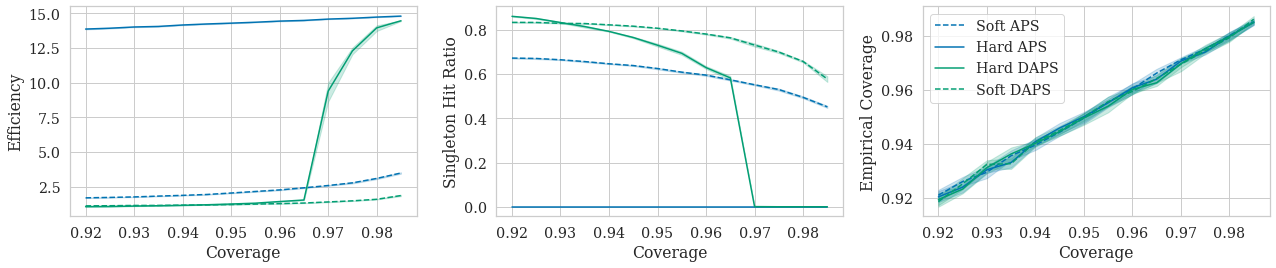

In [21]:
sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)
f, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.lineplot(data=soft_results, x="coverage_guarantee", y="average_set_size", label="Soft Baseline",color="#0173B2", linestyle="--", ax=axs[0])
sns.lineplot(data=hard_results, x="coverage_guarantee", y="average_set_size", label="Hard Baseline", color="#0173B2", ax=axs[0])
sns.lineplot(data=hard_mixed_results, x="coverage_guarantee", y="average_set_size", label="Mixing (Hard)", color="#029E73", ax=axs[0])
sns.lineplot(data=soft_mixed_results, x="coverage_guarantee", y="average_set_size", label="Mixing (Soft)", color="#029E73", linestyle="--",ax=axs[0])

sns.lineplot(data=soft_results, x="coverage_guarantee", y="singleton_hit", label="Soft Baseline", color="#0173B2",linestyle="--", ax=axs[1])
sns.lineplot(data=hard_results, x="coverage_guarantee", y="singleton_hit", label="Hard Baseline", color="#0173B2", ax=axs[1])
sns.lineplot(data=hard_mixed_results, x="coverage_guarantee", y="singleton_hit", label="Mixing (Hard)", color="#029E73", ax=axs[1])
sns.lineplot(data=soft_mixed_results, x="coverage_guarantee", y="singleton_hit", label="Mixing (Soft)", color="#029E73", linestyle="--", ax=axs[1])

sns.lineplot(data=soft_results, x="coverage_guarantee", y="empi_coverage", color="#0173B2", linestyle="--", ax=axs[2], label="Soft APS")
sns.lineplot(data=hard_results, x="coverage_guarantee", y="empi_coverage", color="#0173B2", ax=axs[2], label="Hard APS")
sns.lineplot(data=hard_mixed_results, x="coverage_guarantee", y="empi_coverage", color="#029E73", ax=axs[2], label="Hard DAPS")
sns.lineplot(data=soft_mixed_results, x="coverage_guarantee", y="empi_coverage", color="#029E73", linestyle="--", ax=axs[2], label="Soft DAPS")

axs[0].legend().remove()
axs[1].legend().remove()
axs[2].legend()

axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage")
axs[2].set_xlabel("Coverage")

axs[0].set_ylabel("Efficiency")
axs[1].set_ylabel("Singleton Hit Ratio")
axs[2].set_ylabel("Empirical Coverage")
f.tight_layout()
plt.savefig(os.path.join(figures_dir, "one-hot-reconst.pgf"), format="pgf", bbox_inches='tight')

<AxesSubplot:ylabel='Count'>

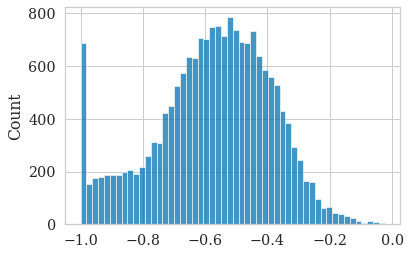

In [17]:
sns.histplot(hard_mixed_scores[true_mask].cpu())

In [31]:
(hard_mixed_scores[true_mask] < -1 + 1e-6).sum() / dataset.x.shape[0]

tensor(0.0261, device='cuda:0')

<AxesSubplot:ylabel='Count'>

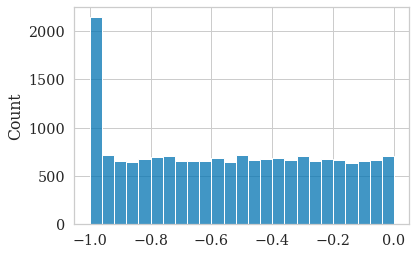

In [28]:
sns.histplot(hard_baseline_scores[true_mask].cpu())

In [32]:
(hard_baseline_scores[true_mask] < -1 + 1e-6).sum() / dataset.x.shape[0]

tensor(0.0823, device='cuda:0')